# Coordinate Reference Systems (CRS) and Map Projections

Building off of what we learned in the previous notebook, we'll now approach an integral aspect of geospatial data: Coordinate Reference Systems.

<!---
Expected time to complete
    Lecture + Questions: 45 minutes
    Exercises: 10 minutes
-->

In [1]:
import pandas as pd
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline  

## Import Shapefiles

Let's go ahead and bring back in our California county shapefile. As before, we can read the file in using `gpd.read_file` and plot it right away:

<Axes: >

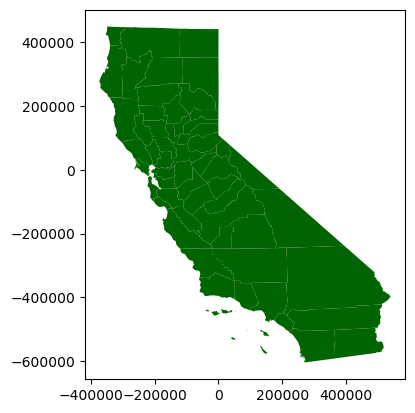

In [2]:
counties = gpd.read_file('../data/california_counties/CaliforniaCounties.shp')
counties.plot(color='darkgreen')

Even if we have an awesome map like this, sometimes we want to have more geographical context, or we just want additional information. We're going to try **overlaying** our counties GeoDataFrame on a United States shapefile.

We'll proceed in a similar manner with the US States shapefile: import the GeoDataFrame, examine it, and plot:

In [3]:
# Read in states shapefile
states = gpd.read_file('../data/us_states/us_states.shp')

In [4]:
# Look at the first few rows
states.head()

,STATE,GEOID,ABBREV,geometry
0,Alabama,01,AL,"MULTIPOLYGON (((-88.05338 30.50699, -88.05109 ..."
1,Alaska,02,AK,"MULTIPOLYGON (((-134.73726 58.26135, -134.7344..."
2,Arizona,04,AZ,"POLYGON ((-114.81629 32.50804, -114.81432 32.5..."
3,Arkansas,05,AR,"POLYGON ((-94.61783 36.49941, -94.61765 36.499..."
4,California,06,CA,"MULTIPOLYGON (((-118.60442 33.47855, -118.5987..."


In [5]:
# Count how many rows and columns we have
states.shape

(56, 4)

<Axes: >

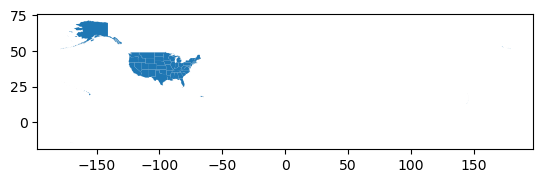

In [6]:
# Plot the states data
states.plot()

You might have noticed that our plot extends beyond the 50 states (which we also saw when we executed the `shape` method). Let's double check what states we have included in our data.

In [7]:
states['STATE'].values

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
       'Kansas', 'Maryland', 'Minnesota', 'Mississippi', 'Montana',
       'Nevada', 'New Jersey', 'New Mexico', 'North Dakota', 'Oklahoma',
       'Pennsylvania', 'South Carolina', 'South Dakota', 'Utah',
       'Vermont', 'West Virginia', 'Wyoming', 'American Samoa',
       'Puerto Rico', 'Florida', 'Kentucky', 'Louisiana', 'Maine',
       'Massachusetts', 'Michigan', 'Missouri', 'Nebraska',
       'New Hampshire', 'New York', 'North Carolina', 'Ohio', 'Oregon',
       'Rhode Island', 'Tennessee', 'Texas', 'Virginia', 'Washington',
       'Wisconsin', 'Guam',
       'Commonwealth of the Northern Mariana Islands',
       'United States Virgin Islands'], dtype=object)

Beyond the 50 states we seem to have American Samoa, Puerto Rico, Guam, Commonwealth of the Northern Mariana Islands, and United States Virgin Islands included in this geodataframe. To make our map cleaner, let's limit the states to the 48 contiguous states (so, we'll also exclude Alaska and Hawaii).

In [8]:
# Define list of non-contiguous states
non_contiguous_us = ['American Samoa',
                     'Puerto Rico',
                     'Guam',
                     'Commonwealth of the Northern Mariana Islands',
                     'United States Virgin Islands',
                     'Alaska',
                     'Hawaii']
# Subselect GeoDataFrame according to above list
states_limited = states.loc[~states['STATE'].isin(non_contiguous_us)]

<Axes: >

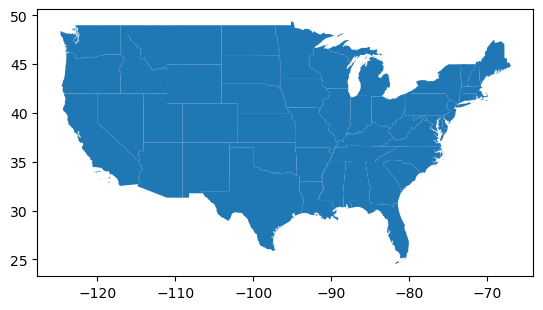

In [9]:
# Plot it
states_limited.plot()

To prepare for our mapping overlay, let's make our states a nice, light grey color:

<Axes: >

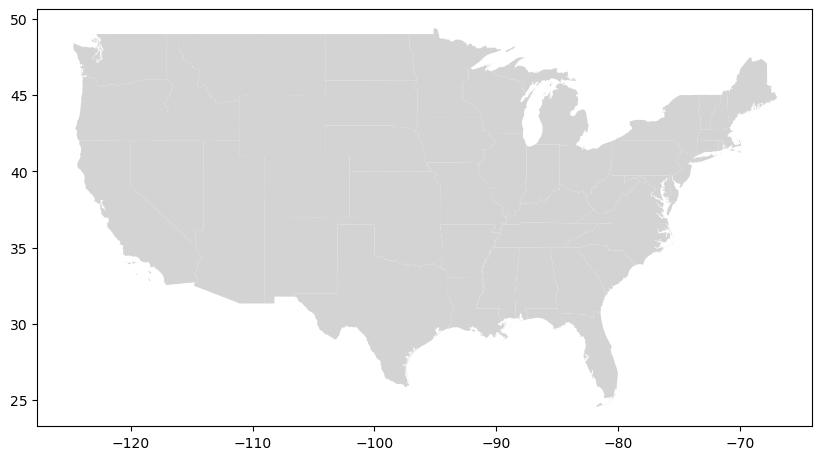

In [10]:
states_limited.plot(color='lightgrey', figsize=(10,10))

## Plotting Multiple Geometries

Now that we have both GeoDataFrames in our environment, we can plot both in the same figure.

To do this, we're going to obtain a matplotlib Axes object (`ax`). We'll then explicitly add each layer to it by providing the `ax=ax` argument to the `plot` method.

This is the *object-oriented* approach to using matplotlib. It may be new to you, but it's very powerful, since it lets you directly choose which subplot you modify.

<Axes: >

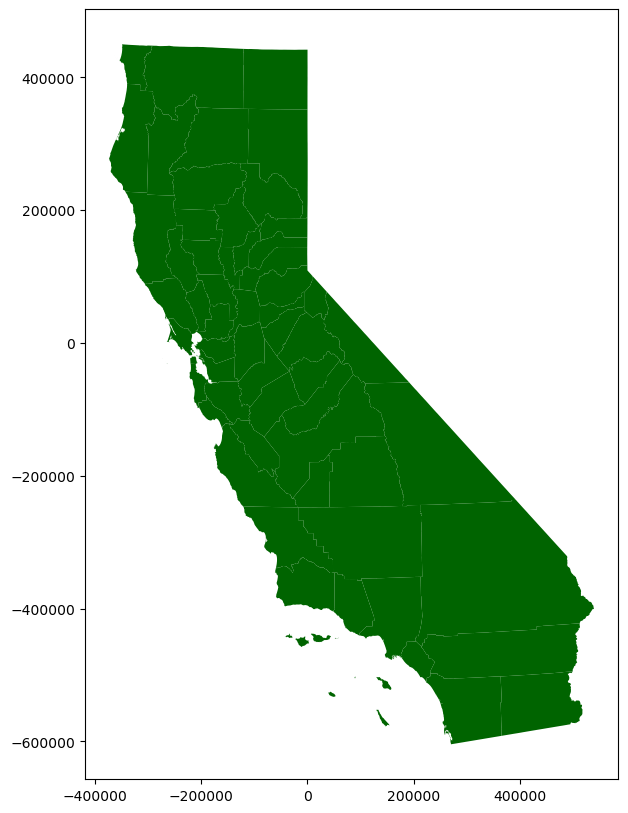

In [11]:
# Create figure and axis object
fig, ax = plt.subplots(figsize=(10, 10))
# Plot counties first
counties.plot(color='darkgreen', ax=ax)
# Plot states next
states_limited.plot(color='lightgrey', ax=ax)

Oh no, what happened here?

If you look at the numbers we have on the $x$ and $y$ axes in our two plots, you'll see that the county data has much larger numbers than our states data. It's represented in some different type of unit other than decimal degrees! 

In fact, that means if we zoom in really close into our plot we'll probably see the states data plotted. 

(20.0, 50.0)

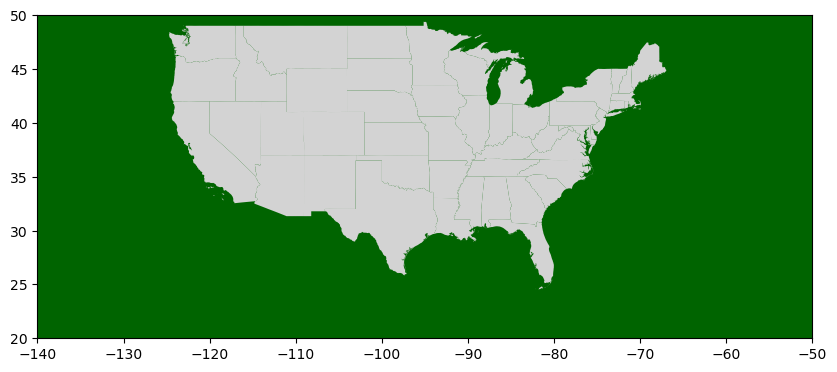

In [12]:
# Create figure and axis object
fig, ax = plt.subplots(figsize=(10, 10))
# Plot counties first
counties.plot(color='darkgreen', ax=ax)
# Plot states next
states_limited.plot(color='lightgrey', ax=ax)
# Change limits of axes
ax.set_xlim(-140, -50)
ax.set_ylim(20, 50)

This is a key issue that you'll have to resolve time and time again when working with geospatial data!

It all revolves around **coordinate reference systems** and **projections**.

## Coordinate Reference Systems (CRS)

A Coordinate Reference System (CRS) describes how the coordinates in a geospatial dataset relate to locations on the surface of the earth. 

A **geographic CRS** consists of: 
- A 3D model of the shape of the earth (a **datum**), approximated as a sphere or spheroid (e.g., an ellipsoid),
- The **units** of the coordinate system (e.g, decimal degrees, meters, feet), and 
- The **origin** (i.e., the 0,0 location), specified as the meeting of the **equator** and the **prime meridian**.

A **projected CRS** consists of:
- A geographic CRS, and
- A **map projection** and related parameters used to transform the geographic coordinates to `2D` space.
  - A map projection is a mathematical model used to transform coordinate data

<img src ="https://www.e-education.psu.edu/natureofgeoinfo/sites/www.e-education.psu.edu.natureofgeoinfo/files/image/projection.gif" height="100" width="500">

### There are Many, Many CRSs

Theoretically, the number of CRSs is unlimited!

Why? There are two main reasons: i) There are many different definitions of the shape of the earth (treating it as a sphere is just too simple!) and ii) There are many different ways to cast its surface onto 2 dimensions. Our understanding of the Earth's shape and our ability to measure it has changed greatly over time.

**So, why are we even bothering with these CRSs?**

- You need to know the data about your data (or `metadata`) to use it appropriately.
- All projected CRSs introduce distortion in shape, area, and/or distance. Understanding what CRS best maintains the characteristics you need for your area of interest and your analysis is important.
- Some analysis methods expect geospatial data to be in a projected CRS
  - For example, GeoPandas expects a GeoDataFrame to be in a projected CRS for area or distance based analyses.
- Some Python libraries, but not all, implement dynamic reprojection from the input CRS to the required CRS and assume a specific CRS (WGS84) when a CRS is not explicitly defined.
- Most Python spatial libraries, including GeoPandas, require geospatial data to be in the same CRS if they are being analysed together.

**That's a lot: what are the basics we need to remember?**

- What CRSs are used in your study area and what are their main characteristics?
- How to identify, or `get`, the CRS of a GeoDataFrame.
- How to **set** the CRS of geodataframe (i.e. define the projection).
- Hot to **transform** the CRS of a GeoDataFrame (i.e. reproject the data).

### EPSG Codes and Commonly Used CRSs

CRSs are typically referenced by an [EPSG code](http://wiki.gis.com/wiki/index.php/European_Petroleum_Survey_Group).  

It's important to know the commonly used CRSs and their EPSG codes for your geographic area of interest.  

For example, below is a list of commonly used CRSs for California geospatial data along with their EPSG codes.

**Geographic CRSs**

* `4326: WGS84` (units decimal degrees): The most commonly used geographic CRS.
* `4269: NAD83` (units decimal degrees): The geographic CRS customized to best fit the USA. This is used by all Census geographic data.

`NAD83 (EPSG:4269)` is approximately the same as `WGS84 (EPSG:4326)`, although locations can differ by up to 1 meter in the continental USA and elsewhere up to 3 meters. That is not a big issue with, for example, Census tract data as these data are only accurate within 7 meters.

**Projected CRSs**

* `5070: CONUS NAD83` (units meters): Projected CRS for mapping the entire contiguous USA (CONUS).
* `3857: Web Mercator` (units meters): Conformal (shape preserving) CRS used as the default in web mapping.
* `3310: CA Albers Equal Area, NAD83` (units meters): Projected CRS for CA statewide mapping and spatial analysis.
* `26910: UTM Zone 10N, NAD83` (units meters): Projected CRS for northern CA mapping & analysis.
* `26911: UTM Zone 11N, NAD83` (units meters): Projected CRS for Southern CA mapping & analysis.
* `102641 to 102646: CA State Plane zones 1-6, NAD83` (units feet): Projected CRS used for local analysis.

You can find the full CRS details on [this website](https://www.spatialreference.org).

## Working with CRSs in GeoPandas

Now that we've covered some of the basics, let's turn back to the code. Even though there are a lot of details, GeoPandas actually makes it pretty easy to work with CRSs!

### Identifying the CRS of a GeoDataFrame

GeoPandas GeoDataFrames have a `crs` attribute that returns the CRS of the data:

In [13]:
counties.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [14]:
states_limited.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

As we can clearly see from those two printouts (even if we don't understand all the content!),
the CRSs of our two datasets are different! **This explains why we couldn't overlay them correctly!**


The above CRS definition specifies:
- the name of the CRS (`WGS84`), 
- the axis units (`degree`),
- the shape (`datum`),
- the origin (`Prime Meridian`, and the equator),
- and the area for which it is best suited (`World`)

Some additional terms worth noting:
- `geocentric`: latitude and longitude assume a spherical (round) model of the shape of the earth.
- `geodetic`: latitude and longitude assume a spheriodal (ellipsoidal) model, which is closer to the true shape.
- `geodesy`: is the study of the shape of the earth.

**NOTE**: If you print a `crs` call, Python will just display the EPSG code used to initiate the CRS object. Depending on your versions of GeoPandas and its dependencies, this may or may not look different from what we just saw above.

In [15]:
print(states_limited.crs)

EPSG:4326


### Setting the CRS

You can also set the CRS of a GeoDataFrame using the `crs` attribute.  You should set the CRS if is not defined or if you think it is incorrectly defined.

> In desktop GIS terminology, setting the CRS is called **defining the CRS**.

As an example, let's set the CRS of our data to `None`:

In [16]:
# First, set the CRS to None
states_limited.crs = None

In [17]:
# Check it again
states_limited.crs

Makes sense: if a variable has a null value (`None`), then displaying it without printing it won't display anything!

In [18]:
# Check it again
print(states_limited.crs)

None


Now, we'll set it back to its correct CRS:

In [19]:
# Set it to 4326
states_limited.crs = "epsg:4326"

In [20]:
# Show it
states_limited.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**NOTE**: You can set the CRS to anything you like, but **that doesn't make it correct**! This is because setting the CRS does not change the coordinate data. It just tells the software how to interpret it.

### Transforming or Reprojecting the CRS

You can transform the CRS of a GeoDataFrame with the `to_crs` method.

> In desktop GIS terminology transforming the CRS is called **projecting the data** (or **reprojecting the data**).

When you do this, you should save the output to a new GeoDataFrame.

In [21]:
states_limited_utm10 = states_limited.to_crs("epsg:26910")

Now, take a look at the new CRS:

In [22]:
states_limited_utm10.crs

<Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 126°W and 120°W - onshore and offshore. Canada - British Columbia; Northwest Territories; Yukon. United States (USA) - California; Oregon; Washington.
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

You can see the result immediately by plotting the data.

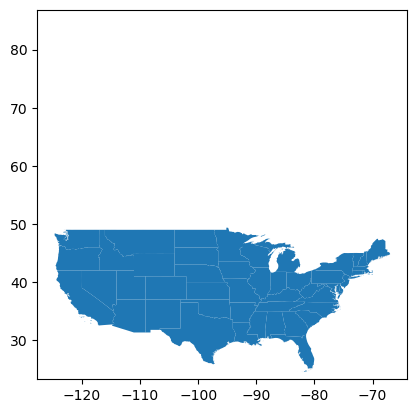

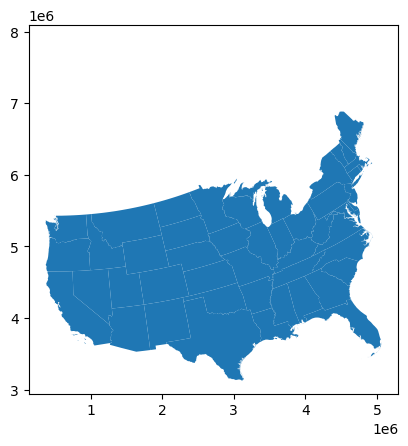

In [23]:
# Plot geographic gdf
states_limited.plot();
plt.axis('square');

# Plot UTM gdf
states_limited_utm10.plot();
plt.axis('square')

plt.show()

---

### Challenge 1: Reflecting on CRSs

1. What two key differences do you see between the two plots above?
2. Do either of these plotted USA maps look good?
3. Try looking at the common CRS EPSG codes above and see if any of them look better for the whole country than what we have now. Then try transforming the states data to the CRS that you think would be best and plotting it. (Use the code cell two cells below.)

---

(-2586829.4388886895,
 2488915.8729062313,
 124423.84046021817,
 5200169.152255139)

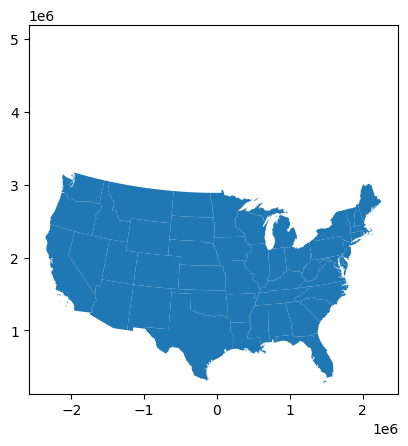

In [24]:
# YOUR CODE HERE
# Using EPSG:5070 because it's good for CONUS
states_limited_conus = states_limited.to_crs("epsg:5070")
states_limited_conus.plot()
plt.axis('square')

## Plotting States and Counties Together

Now that we know what a CRS is and how we can set them, let's turn back to our original issue. We're going to match up our counties GeoDataFrame's CRS to the states GeoDataFrame's CRS.

In [25]:
# Convert counties data to WGS 84
counties_wgs84 = counties.to_crs("epsg:4326")

<Axes: >

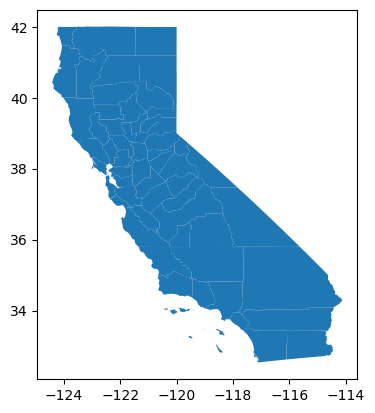

In [26]:
counties_wgs84.plot()

<Axes: >

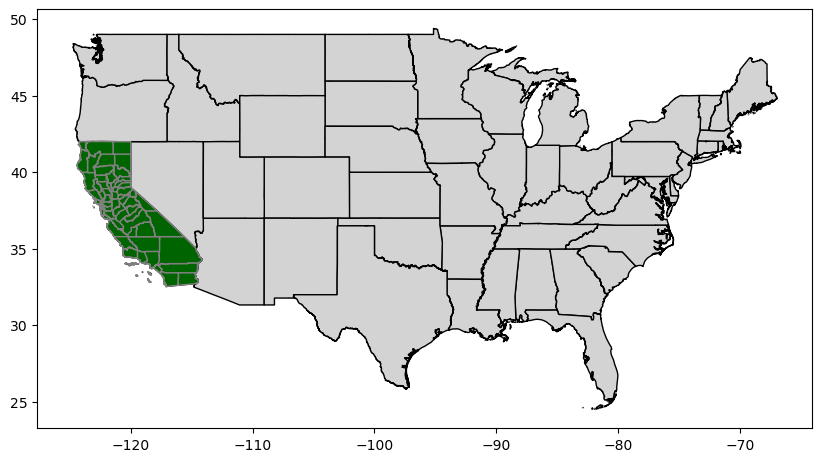

In [27]:
# Plot it together!
fig, ax = plt.subplots(figsize=(10,10))
states_limited.plot(color='lightgrey', edgecolor='black', ax=ax)
counties_wgs84.plot(color='darkgreen', edgecolor='gray', ax=ax)

Since we know that the best CRS to plot the contiguous US from the above question is 5070, let's also transform and plot everything in that CRS.

In [28]:
counties_conus = counties.to_crs("epsg:5070")
states_limited_conus = states_limited.to_crs("epsg:5070")

<Axes: >

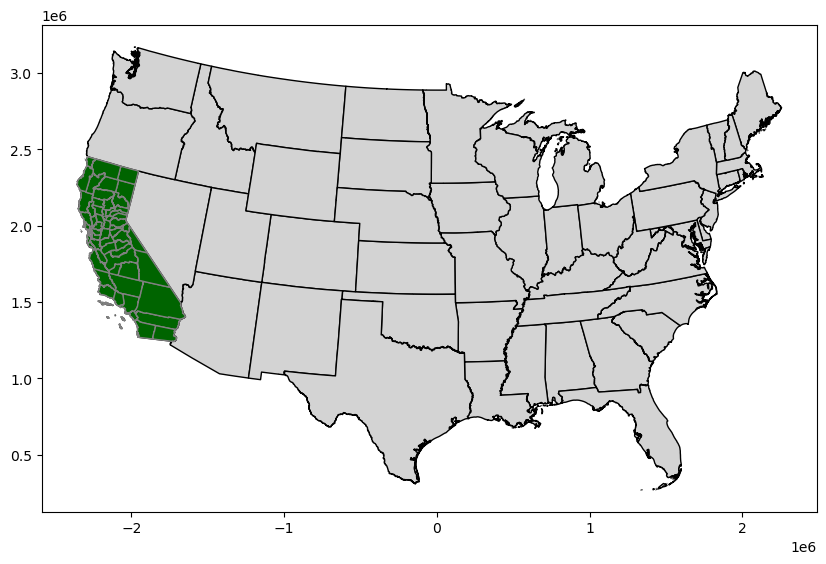

In [29]:
# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10,10))
# Plot the EPSG:5070 projections
states_limited_conus.plot(color='lightgrey', edgecolor='black', ax=ax)
counties_conus.plot(color='darkgreen', edgecolor='gray', ax=ax)

--- 
### Challenge 2: CRS Management

Now it's time to take a crack and managing the CRS of a new dataset. In the code cell below, write code to:

1. Bring in the CA places data (`../data/census/Places/cb_2018_06_place_500k.zip`)
2. Check if the CRS is EPSG code 26910. If not, transform the CRS.
3. Plot the California counties and places together.

---

In [30]:
# YOUR CODE HERE
# 1. Bring in the CA places data
california_places = gpd.read_file('zip://../data/census/Places/cb_2018_06_place_500k.zip')
california_places.head()

,STATEFP,PLACEFP,PLACENS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,06,46492,02411054,1600000US0646492,0646492,Maywood,25,3052102,0,"POLYGON ((-118.20416 33.98952, -118.20433 33.9..."
1,06,17750,02410282,1600000US0617750,0617750,Cypress,25,17127728,21850,"POLYGON ((-118.06332 33.83153, -118.06123 33.8..."
2,06,56938,02411418,1600000US0656938,0656938,Piedmont,25,4402167,0,"POLYGON ((-122.24930 37.82372, -122.24812 37.8..."
3,06,69088,02411819,1600000US0669088,0669088,Santa Clarita,25,170638259,162849,"MULTIPOLYGON (((-118.56481 34.35969, -118.5591..."
4,06,13392,02409461,1600000US0613392,0613392,Chula Vista,25,128547314,6380537,"POLYGON ((-117.12399 32.64636, -117.11707 32.6..."


In [31]:
# 2. Check if the CRS is EPSG code 26910. If not, transform the CRS.
california_places.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [32]:
# 2a. Transform the CRS to 26910
california_places_utm10 = california_places.to_crs("epsg:26910")
california_places_utm10.crs

<Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 126°W and 120°W - onshore and offshore. Canada - British Columbia; Northwest Territories; Yukon. United States (USA) - California; Oregon; Washington.
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [33]:
counties_utm10 = counties.to_crs("epsg:26910")

<Axes: >

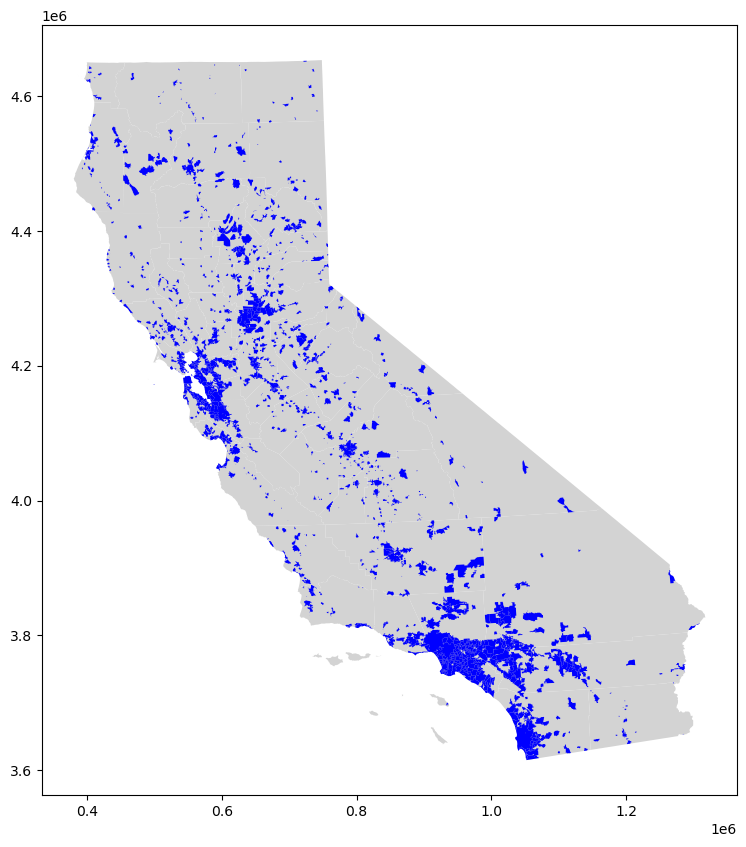

In [35]:
#3. Plot the California counties and places together.
fig, ax = plt.subplots(figsize=(10, 10))
counties_utm10.plot(color='lightgrey', ax=ax)
california_places_utm10.plot(color='blue', ax=ax)